In [1]:
import os
import pandas as pd
import numpy as np
import datetime
from select_disease_cohort import standardize_codes_and_select_cohort
from select_patient_info import get_patient_df, partition_by_readmit

# Constants
GROUP_COL = 'subject_id'
VISIT_COL = 'hadm_id'
ADMIT_COL = 'admittime'
DISCH_COL = 'dischtime'
GAP = datetime.timedelta(days=30) # Gap for within readmission must occur

# Pick disease of interest: 
# I50 = Heart Failure, 
# I25 = Coronary Artery Disease, 
# N18 = Chronic Kidney Disease, 
# J44 = Chronic obstructive pulmonary disease
DISEASE_LABEL = 'I50' 

# Paths
PATH_ADMISSIONS: str = os.path.join("mimiciv", "1.0", "core", "admissions.csv.gz")
PATH_DIAGNOSES_ICD: str = os.path.join("mimiciv", "1.0", "hosp", "diagnoses_icd.csv.gz")
PATH_PATIENTS: str = os.path.join("mimiciv", "1.0", "core", "patients.csv.gz")
PATH_ICD_MAP: str = os.path.join("utils", "ICD9_to_ICD10_mapping.txt")

# Loading admissions, selecting disease cohort

In [2]:
# From admissions df, standardize ICD codes (9 and 10 are mixed) and select disease cohort based on disease label (ICD10), delete patients with death during visit
# Examples: I50 = Heart Failure, I25 = Coronary Artery Disease, N18 = Chronic Kidney Disease, J44 = Chronic obstructive pulmonary disease
# Function defaults to 'I50

visit_df = standardize_codes_and_select_cohort(disease_label="I50", path_admissions_df=PATH_ADMISSIONS)

8/5280351 rows processed
9/5280351 rows processed
43/5280351 rows processed
50/5280351 rows processed
51/5280351 rows processed
55/5280351 rows processed
59/5280351 rows processed
70/5280351 rows processed
71/5280351 rows processed
76/5280351 rows processed
77/5280351 rows processed
79/5280351 rows processed
86/5280351 rows processed
87/5280351 rows processed
89/5280351 rows processed
92/5280351 rows processed
137/5280351 rows processed
138/5280351 rows processed
139/5280351 rows processed
141/5280351 rows processed
154/5280351 rows processed
171/5280351 rows processed
175/5280351 rows processed
181/5280351 rows processed
182/5280351 rows processed
184/5280351 rows processed
185/5280351 rows processed
187/5280351 rows processed
230/5280351 rows processed
231/5280351 rows processed
3832/5280351 rows processed
3833/5280351 rows processed
3835/5280351 rows processed
3838/5280351 rows processed
3867/5280351 rows processed
3872/5280351 rows processed
3877/5280351 rows processed
3954/5280351

In [3]:
visit_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,los,los_hours
132,11309329,25435133,2128-11-27 18:41:00,2128-11-27 21:50:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,ENGLISH,MARRIED,WHITE,2128-11-27 13:38:00,2128-11-27 21:50:00,0,0 days 03:09:00,3
4263,13176993,27459197,2122-03-16 22:23:00,2122-04-11 10:30:00,NaN,ELECTIVE,NaN,HOME HEALTH CARE,Other,ENGLISH,NaN,UNABLE TO OBTAIN,NaN,NaN,0,25 days 12:07:00,612
5931,16735779,27051404,2139-09-28 00:17:00,2139-10-04 21:45:00,NaN,ELECTIVE,NaN,HEALTHCARE FACILITY,Other,ENGLISH,NaN,WHITE,NaN,NaN,0,6 days 21:28:00,165
7632,11359914,29884267,2137-04-06 15:51:00,2137-04-06 17:50:00,NaN,DIRECT OBSERVATION,PHYSICIAN REFERRAL,NaN,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0,0 days 01:59:00,2
7633,19797689,26541624,2188-01-08 20:15:00,2188-01-10 11:30:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,WIDOWED,BLACK/AFRICAN AMERICAN,2188-01-08 14:42:00,2188-01-08 21:28:00,0,1 days 15:15:00,39


# Adding patient df info

In [4]:
# Appends data from patients df to visit_df, specifically the anchor_year, anchor_age, yob, min_valid_year, dod, gender
# I.e. age and gender information for each visit
visit_pts_df = get_patient_df(visit_df=visit_df)

In [ ]:
#These are expensive to run, so we write to 'output' folder
case_df, control_df, invalid_df = partition_by_readmit(visit_pts_df,gap=datetime.timedelta(days=30),group_col=GROUP_COL,visit_col=VISIT_COL,admit_col=ADMIT_COL,disch_col=DISCH_COL)
case_df.to_csv('output/case_df.csv')
control_df.to_csv('output/control_df.csv',index_label=False)
invalid_df.to_csv('output/invalid_df.csv',index_label=False)

# case_df = pd.read_csv('output/case_df.csv')
# control_df = pd.read_csv('output/control_df.csv')
# invalid_df = pd.read_csv('output/invalid_df.csv')

100%|██████████| 23866/23866 [07:50<00:00, 50.78it/s]


[ READMISSION LABELS FINISHED ]


In [26]:
#invalid_df

""


# Sanity checks

<Axes: >

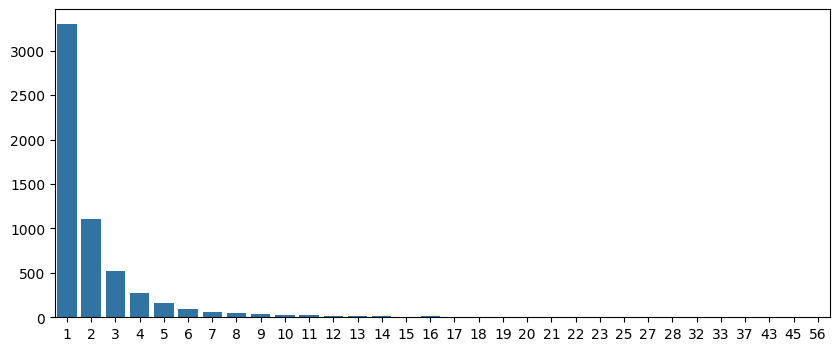

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for number of readmissions per patient, how much redundancy is there w.r.t. age, gender, ethnicity, insurance etc.?
values, counts = np.unique(case_df.groupby('subject_id').count()['hadm_id'].values,return_counts=True)

# Doesn't seem so bad, most people have just a couple of readmissions
plt.figure(figsize=(10,4))
sns.barplot(x=values,y=counts)

In [22]:
# Check for missing values in all columns
# Also seems OK, date of death can probably be dropped
case_df.isnull().sum()

subject_id                0
hadm_id                   0
admittime                 0
dischtime                 0
los                       0
los_hours                 0
admission_type            0
admission_location        0
discharge_location     1432
insurance                 0
ethnicity                 0
marital_status           53
anchor_year               0
anchor_age                0
yob                       0
min_valid_year            0
dod                   10378
gender                    0
age                       0
dtype: int64

In [36]:
# Suppose we want a dataset with only one readmission per patient, in this case the first readmission after first visit
# We can drop all patients with more than one readmission
case_df_first_readmission = case_df[case_df.groupby('subject_id').cumcount() == 1]
case_df_first_readmission.head()
# Check for missing values in all columns
case_df_first_readmission.isnull().sum()


subject_id               0
hadm_id                  0
admittime                0
dischtime                0
los                      0
los_hours                0
admission_type           0
admission_location       0
discharge_location     290
insurance                0
ethnicity                0
marital_status           8
anchor_year              0
anchor_age               0
yob                      0
min_valid_year           0
dod                   2019
gender                   0
age                      0
dtype: int64

In [37]:
case_df.head()

,subject_id,hadm_id,admittime,dischtime,los,los_hours,admission_type,admission_location,discharge_location,insurance,ethnicity,marital_status,anchor_year,anchor_age,yob,min_valid_year,dod,gender,age
14272,10003502,20459702,2166-02-15 13:06:00,2166-02-19 16:02:00,4 days 02:56:00,99,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,WHITE,MARRIED,2161,86,2075,2170,NaN,F,86
17452,10003637,23487925,2146-01-22 23:08:00,2146-01-26 14:02:00,3 days 14:54:00,87,OBSERVATION ADMIT,EMERGENCY ROOM,HOME HEALTH CARE,Other,OTHER,DIVORCED,2145,57,2088,2148,NaN,M,57
53823,10004401,25753439,2142-08-27 19:56:00,2142-08-29 12:30:00,1 days 16:34:00,41,EW EMER.,EMERGENCY ROOM,HOME,Medicare,WHITE,MARRIED,2141,82,2059,2150,2144-06-18,M,82
49781,10004401,29988601,2144-01-23 07:58:00,2144-02-06 11:45:00,14 days 03:47:00,340,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,WHITE,MARRIED,2141,82,2059,2150,2144-06-18,M,82
50384,10004401,22869003,2144-04-05 09:31:00,2144-04-09 17:30:00,4 days 07:59:00,104,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,WHITE,MARRIED,2141,82,2059,2150,2144-06-18,M,82
